In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
import matplotlib.pyplot as plt
from src.experiments.plot_utils import *
from collections import defaultdict

In [3]:
PLOT_DIR = "../experiments/plots"

BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"
SAVED_INDEX_DIR = BASE_DIR + "saved_index/"
STATS_BASE_FOLDER = BASE_DIR + "stats-experiments/"


RERANK_CONSTRUCTION_DIR = BASE_DIR + "rerank_construction/"
RERANK_SEARCH_DIR = BASE_DIR + "rerank_search/"

SEARCH_WEIGHTS_DIR = BASE_DIR + "search_weights_exps/"

FIGURE_DPI = 200

In [4]:
import scienceplots
plt.style.use([ 'science']) # 'notebook' 'science'
plt.rcParams.update({'font.size': 14})

In [5]:
def get_search_weights_data(params, construction_params, base_folder=SEARCH_WEIGHTS_DIR, prev_experiment_folder=1, bracket_split_char="-"):
    folder = base_folder + get_construction_folder(params, bracket_split_char) + get_hnsw_construction_params_folder(construction_params, bracket_split_char)
    index_folder = get_latest_experiment_folder(folder)

    exps_folder = os.path.join(folder, index_folder)
    exp_folder = os.path.join(folder, index_folder, get_latest_experiment_folder(exps_folder, prev_experiment_folder))

    search_weights_folders = os.listdir(exp_folder)

    search_weights_data = defaultdict(lambda: defaultdict(list)) # text_weight -> ef -> recall

    for search_weights_folder in search_weights_folders:
        if search_weights_folder.startswith("."):
            continue

        search_weights = search_weights_folder.split(bracket_split_char)[1]
        text_weight = float(search_weights.split(",")[0])

        for ef_folder in os.listdir(exp_folder + "/" + search_weights_folder):
            if ef_folder.startswith("."):
                continue
            stats = ef_folder.split("_")
            k = int(stats[0])
            ef = int(stats[1])

            if ef >=k:
                # load results.npz file
                results = np.load(os.path.join(exp_folder, search_weights_folder, ef_folder, "results.npz"))
                # results contains recall_scores, ef_search
                assert ef == results["ef_search"]
                search_weights_data[text_weight][ef].append(results["recall_scores"])

    print(f"Read values for k={k} for dataset size {params.index_size} for {len(search_weights_data[text_weight])} ef values")
    return search_weights_data, k

In [6]:
def plot_heatmap_for_search_weights_data(params, construction_params, search_weights_data, max_ef=float('inf'), plots_dir=PLOT_DIR):
    # search_weights_data is weights -> ef -> list of recall for 100 queries
    # we have 11 values for weights: 0.0 to 1.0, and around 15 for ef
    # for each cell combination, we plot a heatmap of the average of the recall values

    # we plot image weights, so first transform to 1-text_weight
    transformed_data = {}
    for weight, ef_dict in search_weights_data.items():
        new_weight = round(1.0 - weight, 5)
        transformed_data[new_weight] = ef_dict
    weights = sorted(transformed_data.keys())
    efs = sorted({ef for ef_dict in transformed_data.values() for ef in ef_dict if ef <= max_ef})

    heatmap_data = np.zeros((len(weights), len(efs)))

    for i, weight in enumerate(weights):
        for j, ef in enumerate(efs):
            recall_list = transformed_data[weight][ef]
            assert len(recall_list) > 0, f"Missing data for weight {weight} and ef {ef}"
            heatmap_data[i, j] = np.mean(recall_list)

    plt.figure(figsize=(10, 6))
    im = plt.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', vmin=0.3, vmax=1) #viridis, YlGn, summer

    plt.xticks(ticks=np.arange(len(efs)), labels=efs)
    plt.yticks(ticks=np.arange(len(weights)), labels=[f"{w:.1f}" for w in weights])

    plt.xlabel("efSearch")
    plt.ylabel("Image Search Weight (1 - Text Search Weight)")
    plt.title(f"Recall Heatmap with Index Weights [{round(params.weights[0], 5)}, {round(params.weights[1], 5)}]")

    plt.colorbar(im, label="Average Recall")

    plt.tight_layout()

    # save plot
    if not os.path.exists(f"{plots_dir}/search_weights"):
        os.makedirs(f"{plots_dir}/search_weights")
    print(params.weights[0],int(params.weights[0]*100))
    plt.savefig(f"{plots_dir}/search_weights/recall_heatmap_{params.index_size}_{params.metrics[0]}_{params.metrics[1]}_weight_{int(params.weights[0]*100)}_ef{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [7]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=100_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Read values for k=50 for dataset size 100000 for 26 ef values


0.5 50


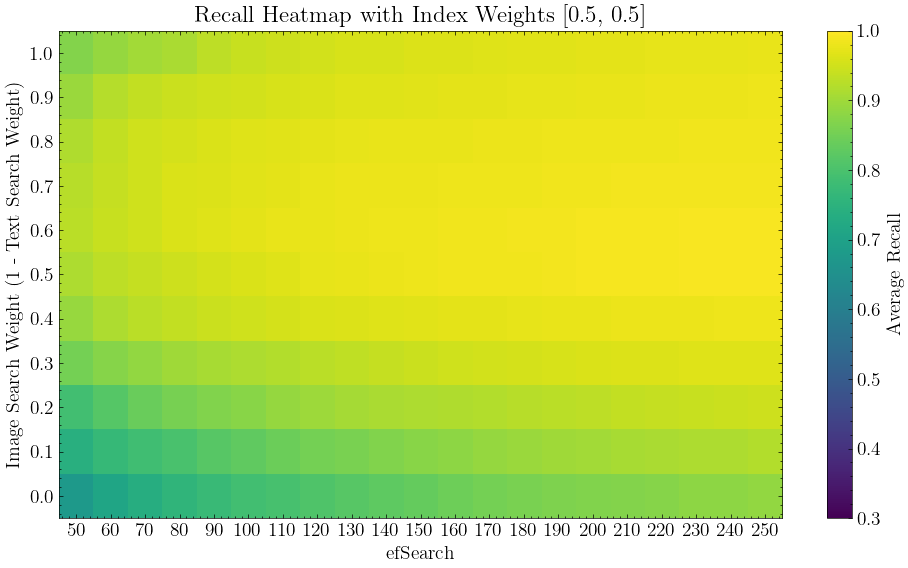

In [16]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [17]:
search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[0.5, 0.5], index_size=1_000_000)
search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=3)

prev_experiment_folder = 1
search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, prev_experiment_folder=prev_experiment_folder, bracket_split_char=":")
search_weights_exp_params.k = k

Read values for k=50 for dataset size 1000000 for 36 ef values


0.5 50


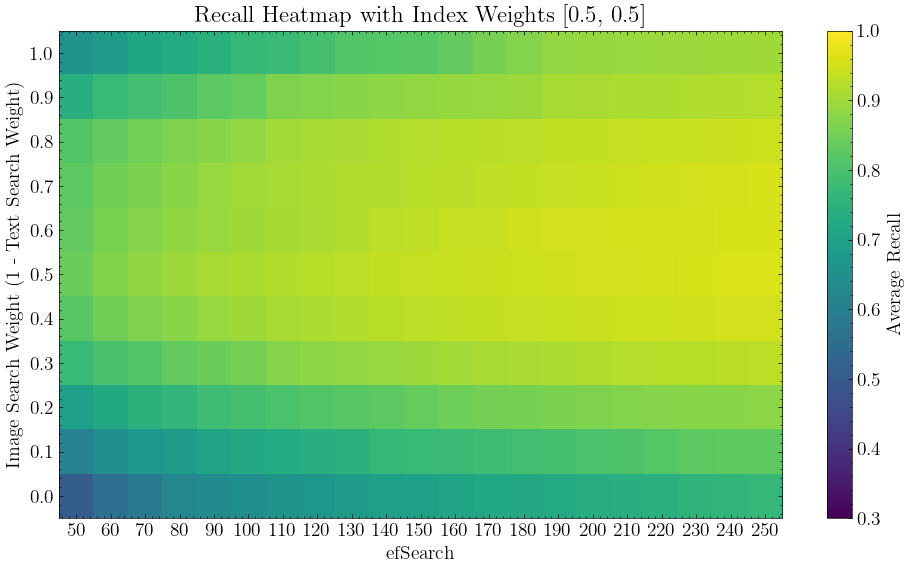

In [18]:
plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [19]:
stats_search_exps_folder = STATS_BASE_FOLDER + "search_weights_exps/"

Read values for k=50 for dataset size 1000000 for 36 ef values
0.0 0


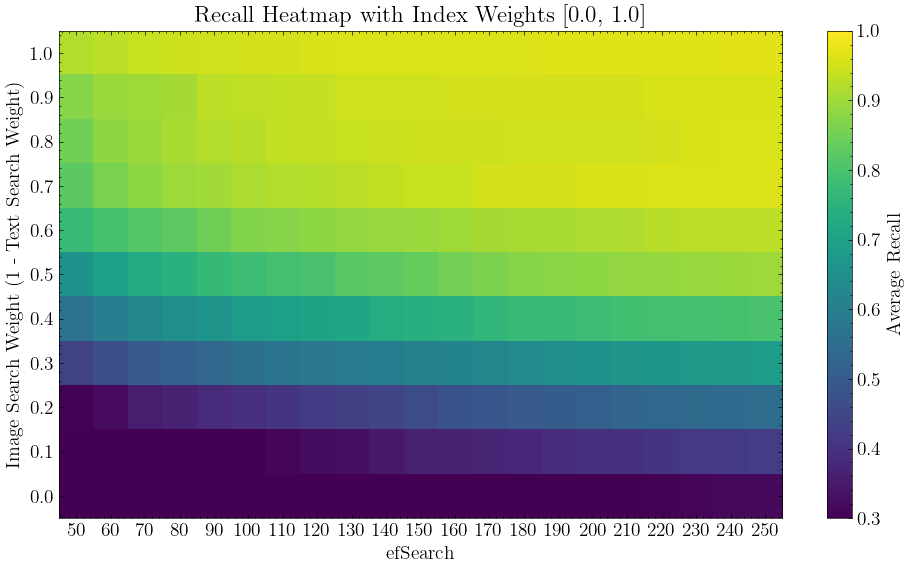

Read values for k=50 for dataset size 1000000 for 36 ef values
0.1 10


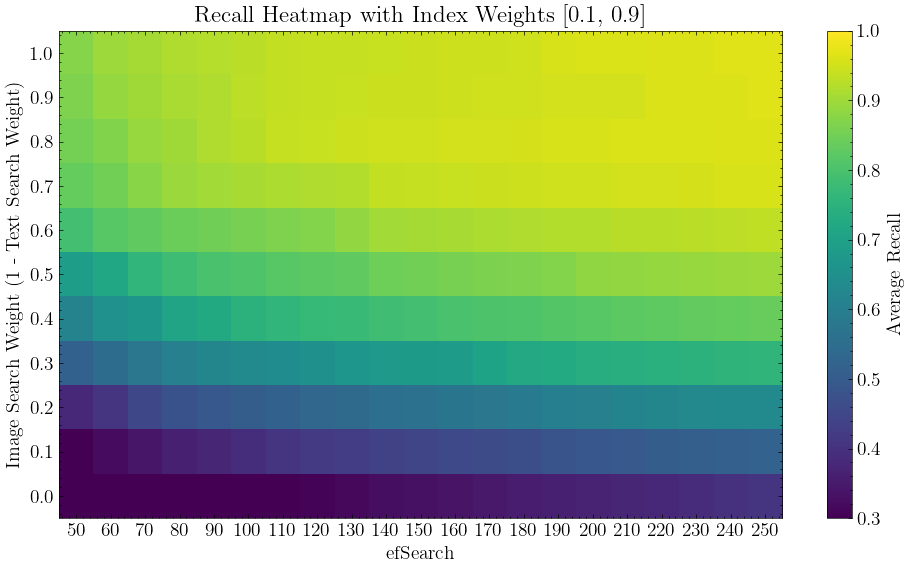

Read values for k=50 for dataset size 1000000 for 36 ef values
0.2 20


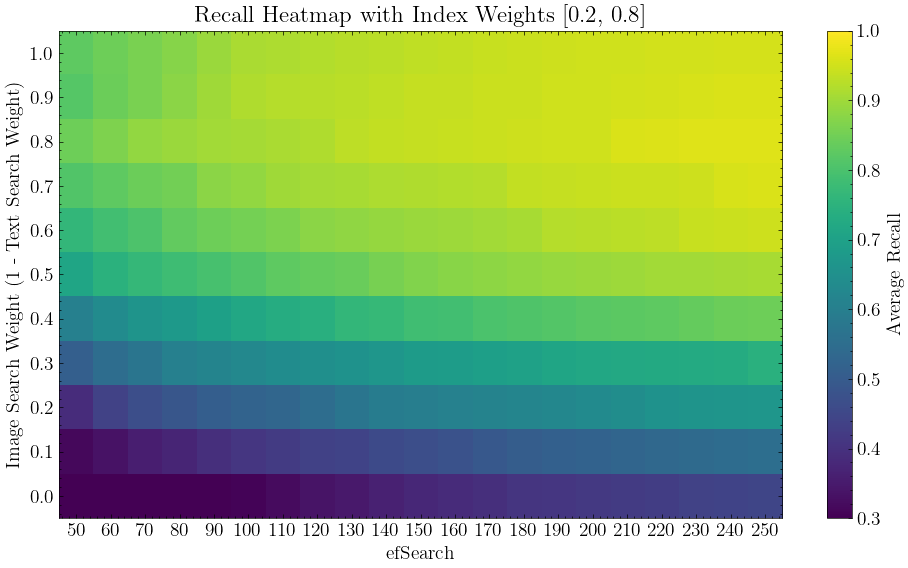

Read values for k=50 for dataset size 1000000 for 36 ef values
0.3 30


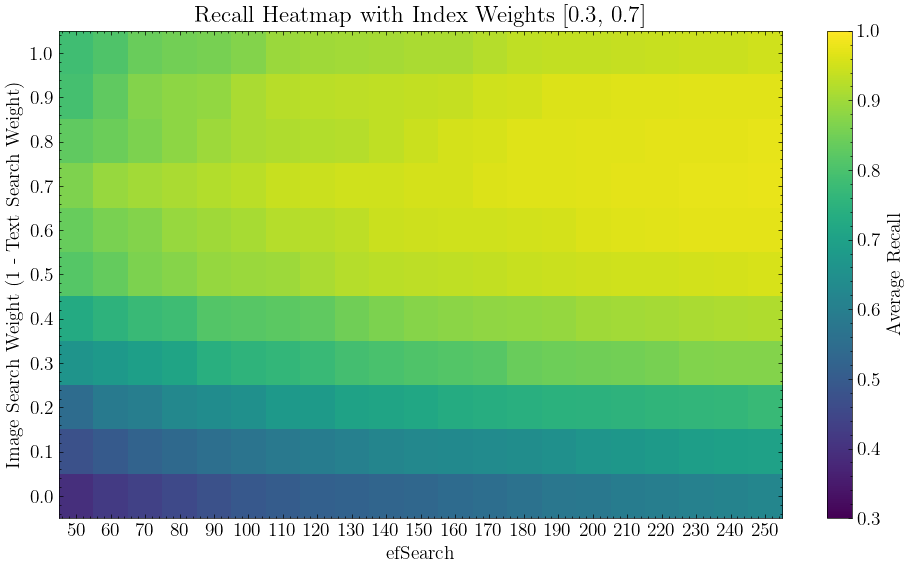

Read values for k=50 for dataset size 1000000 for 36 ef values
0.4 40


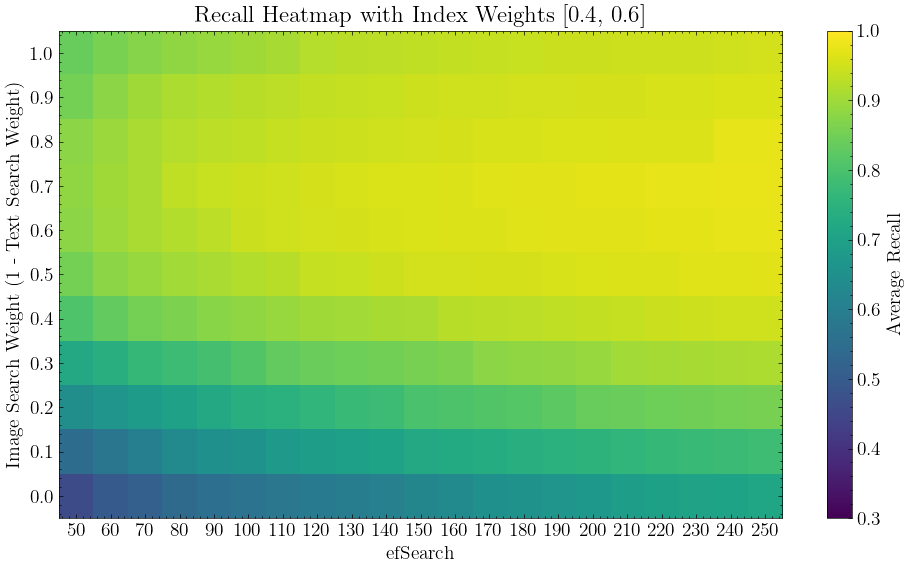

Read values for k=50 for dataset size 1000000 for 36 ef values
0.5 50


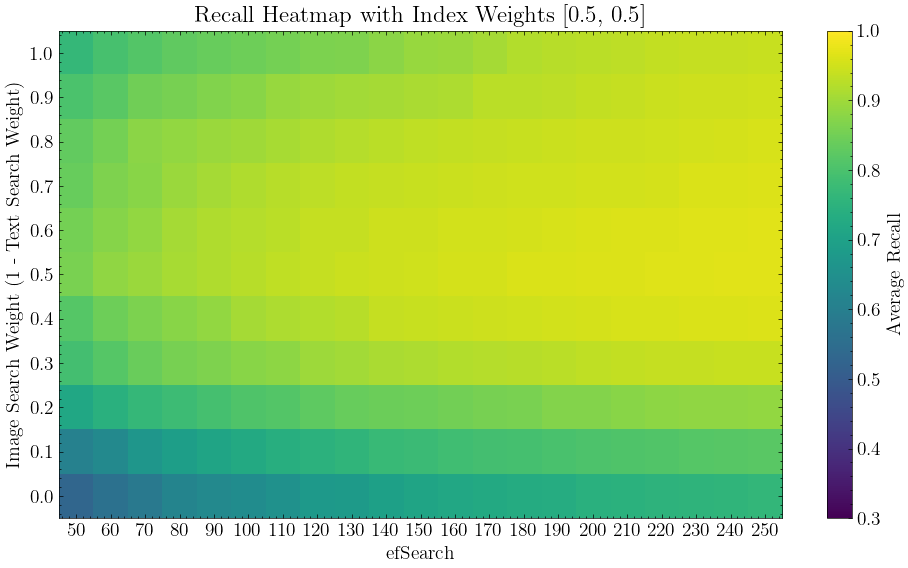

Read values for k=50 for dataset size 1000000 for 36 ef values
0.6 60


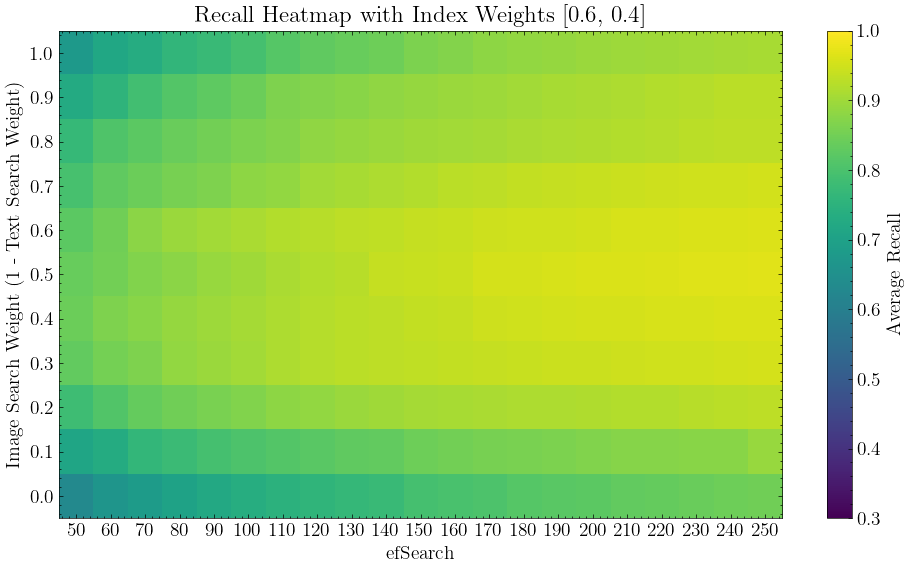

Read values for k=50 for dataset size 1000000 for 36 ef values
0.7 70


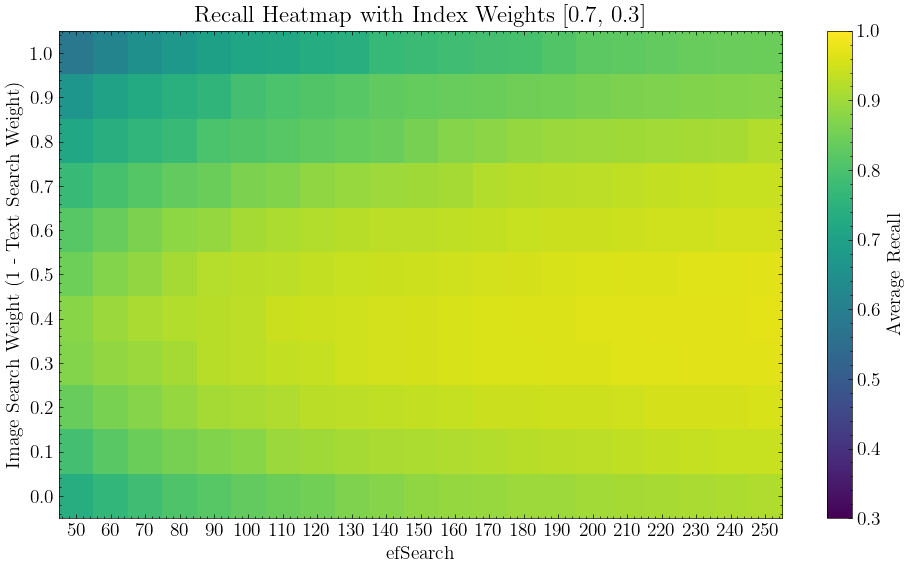

Read values for k=50 for dataset size 1000000 for 36 ef values
0.8 80


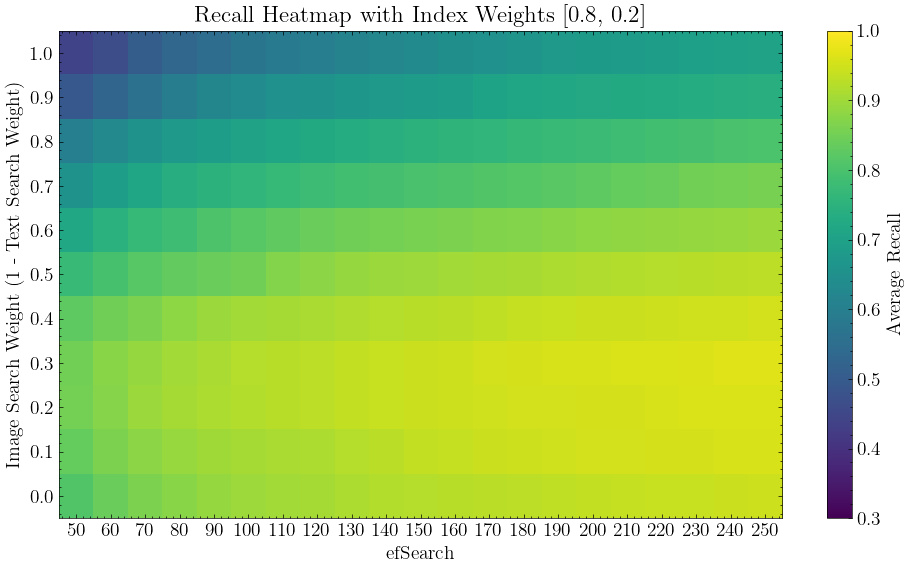

Read values for k=50 for dataset size 1000000 for 36 ef values
0.9 90


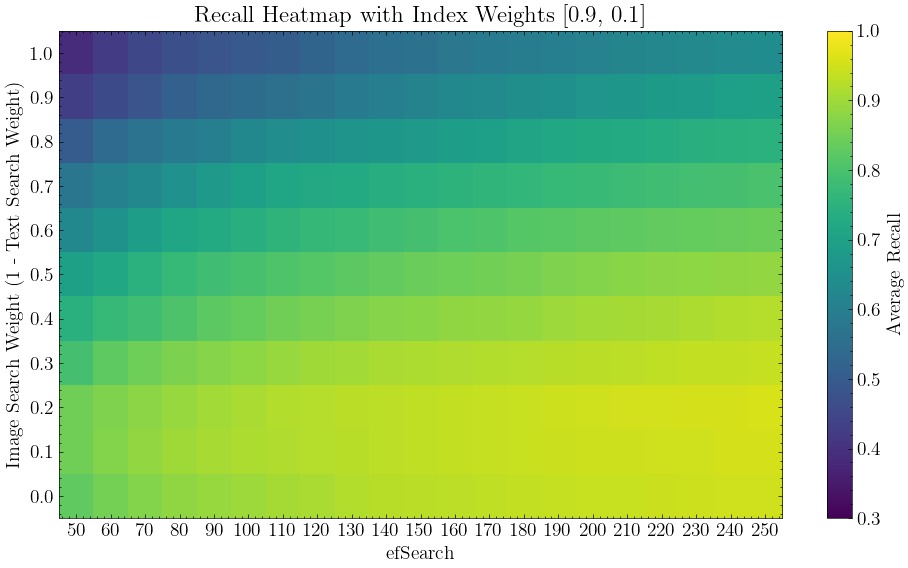

Read values for k=50 for dataset size 1000000 for 36 ef values
1.0 100


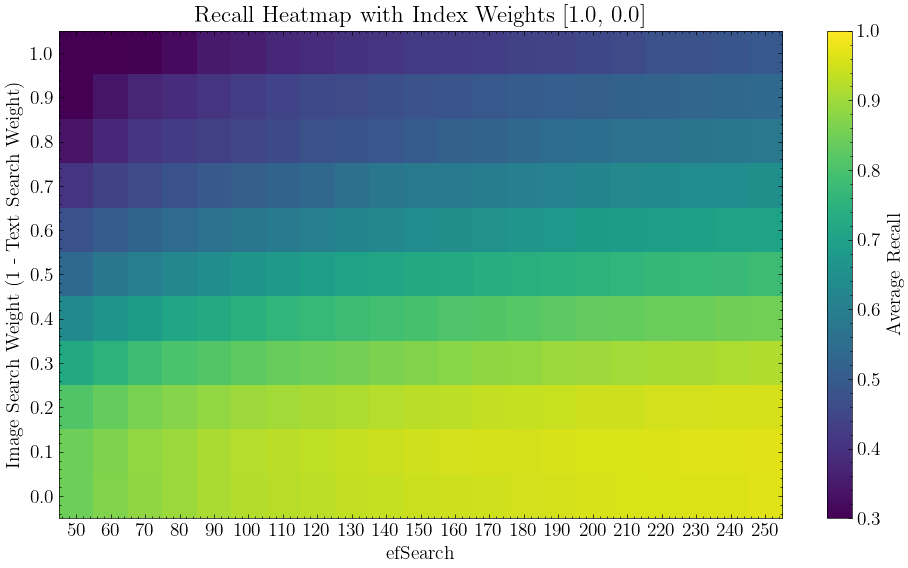

In [20]:
for text_weight in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    search_weights_exp_params = Params(modalities=2, dimensions=[384, 768], metrics=["cosine", "cosine"], weights=[text_weight, round(1-text_weight, 5)], index_size=1_000_000)
    search_weights_construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)

    prev_experiment_folder = 1
    search_weights_data, k = get_search_weights_data(search_weights_exp_params, search_weights_construction_params, base_folder=stats_search_exps_folder, prev_experiment_folder=prev_experiment_folder)
    search_weights_exp_params.k = k

    plot_heatmap_for_search_weights_data(search_weights_exp_params, search_weights_construction_params, search_weights_data, max_ef=250)

In [8]:
def get_construction_stats(params, construction_params, base_folder=STATS_BASE_FOLDER, bracket_split_char="-", normalised=""):
    folder = base_folder + "construction/" + normalised + get_construction_folder(params, bracket_split_char) + get_hnsw_construction_params_folder(construction_params, bracket_split_char)
    data_file = get_latest_experiment_folder(folder)
    # load data file .npz
    data = np.load(os.path.join(folder, data_file))
    return data

In [32]:
def plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_dir=PLOT_DIR, plot_time=True, index_seed=None, normalised=""):
    # plot the distance calls for each text weight
    fig, ax = plt.subplots(figsize=(10, 6))
    x_val = list(times.keys())
    assert len(x_val) == len(total_distance_calls), f"Length mismatch: {len(x_val)} vs {len(total_distance_calls)}"
    assert len(x_val) == len(num_lazy_distance_cutoffs), f"Length mismatch: {len(x_val)} vs {len(num_lazy_distance_cutoffs)}"

    # plot times on the same plot but on the right y-axis
    if plot_time:
        ax1 = ax
        ax1.plot(times.keys(), times.values(), label="Construction Time", color='red', marker='s', zorder=20)
        ax1.set_ylim(400, 1500)
        ax1.set_ylabel("Construction Time (s)", color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.set_xlabel("Index Text Weight (1- Image Weight)")

    if plot_time:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    ax2.plot(total_distance_calls.keys(), total_distance_calls.values(), label="Total Distance Computations", marker='o', zorder=30)
    ax2.plot(num_lazy_distance_cutoffs.keys(), num_lazy_distance_cutoffs.values(), label="Total Distance Computations Cutoff", marker='^', zorder=29)
    ax2.set_ylabel("Number of Distance Computations")

    if plot_time:
        # plot ax on top of ax2
        ax1.set_zorder(11)
        ax2.set_zorder(12)
        ax1.patch.set_visible(False)

        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")

    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")

    ax.set_title(f"1M Index Construction Stats for Metrics [{params.metrics[0].capitalize()}, {params.metrics[1].capitalize()}]")

    if plot_time:
        # combine legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines2 += lines
        labels2 += labels
        ax2.legend(lines2, labels2) #loc="upper left")
    else:
        ax2.legend()

    ax2.grid()
    if plot_time:
        ax1.grid(axis="x")

    # save plot
    if not os.path.exists(f"{plot_dir}/weights-construction"):
        os.makedirs(f"{plot_dir}/weights-construction")
    plt.savefig(f"{plot_dir}/weights-construction/distance_calls_{normalised.split('/')[0]}{params.index_size}_{params.metrics[0]}-{params.metrics[1]}_seed_{index_seed}.pdf", dpi=FIGURE_DPI, bbox_inches='tight', format='pdf')
    plt.show()

In [33]:
def get_construction_data_per_metric_and_seed(metrics, seed=60, normalised=""):
    times = {}
    num_compute_distance_calls = {}
    num_lazy_distance_calls = {}
    total_distance_calls = {}
    num_lazy_distance_cutoffs = {}  # = num_vectors_skipped_due_to_cutoff, since modality is 1
    for text_weight in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

        params = Params(modalities=2, dimensions=[384, 768], metrics=metrics, weights=[text_weight, round(1-text_weight, 5)], index_size=1_000_000)
        construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=seed)

        data = get_construction_stats(params, construction_params, normalised=normalised)
        times[text_weight] = data["time"]
        num_compute_distance_calls[text_weight] = data["num_compute_distance_calls"]
        num_lazy_distance_calls[text_weight] = data["num_lazy_distance_calls"]
        num_lazy_distance_cutoffs[text_weight] = data["num_vectors_skipped_due_to_cutoff"]
        total_distance_calls[text_weight] = num_compute_distance_calls[text_weight] + num_lazy_distance_calls[text_weight]

    # for weights 0.0 and 1.0, every distance call is cutoff, but these aren't captured in the stats above so we manually set them
    num_lazy_distance_cutoffs[1.0] = total_distance_calls[1.0]
    num_lazy_distance_cutoffs[0.0] = total_distance_calls[0.0]

    return params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs

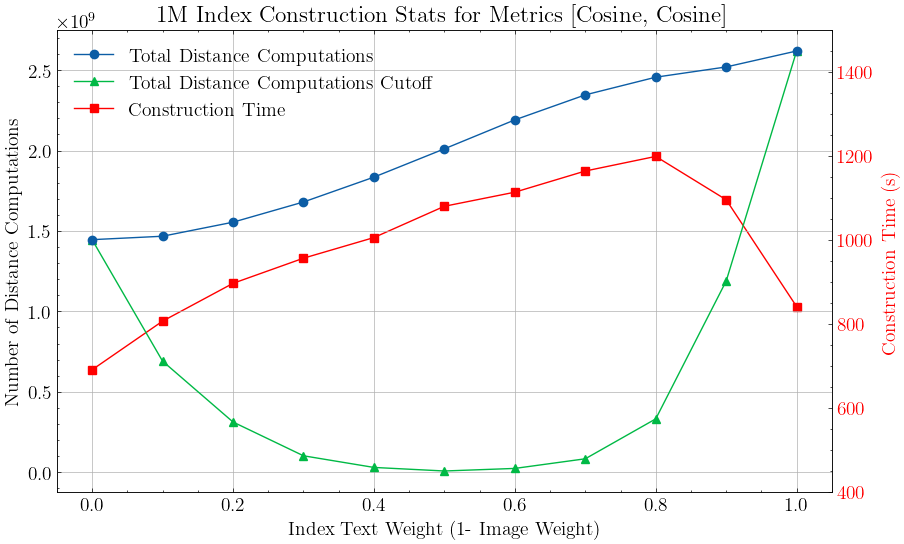

In [34]:
seed = 60
params, times, _, _, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["cosine", "cosine"], seed=seed)
plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

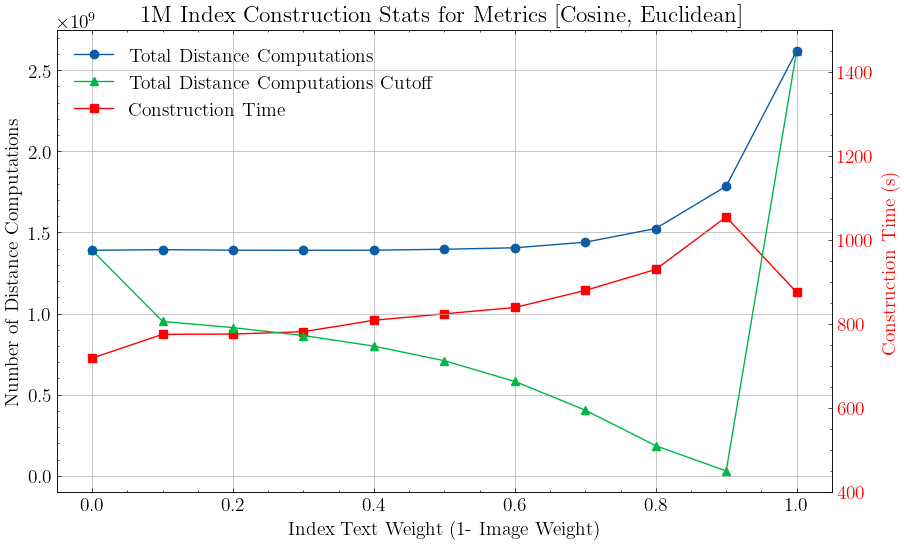

In [35]:
seed = 60
params, times, _, _, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["cosine", "euclidean"], seed=seed)
plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

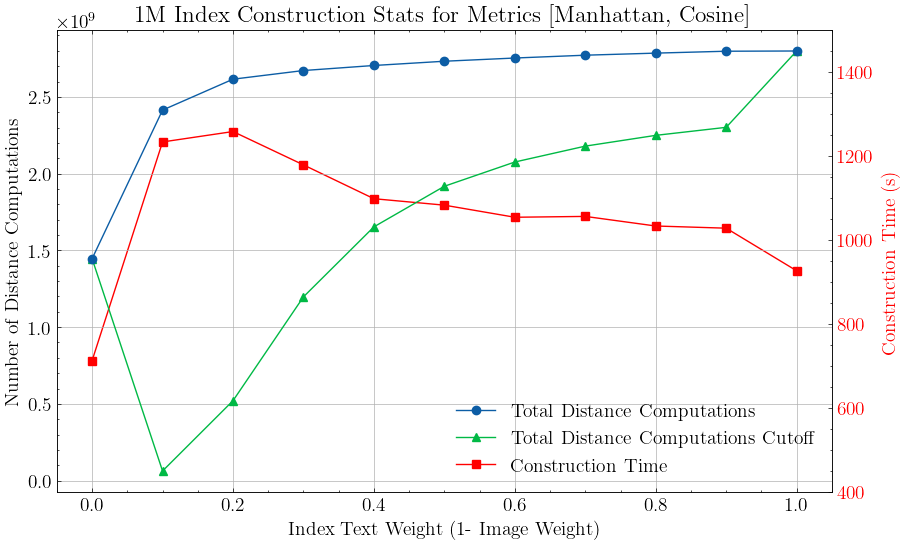

In [36]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["manhattan", "cosine"], seed=60)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

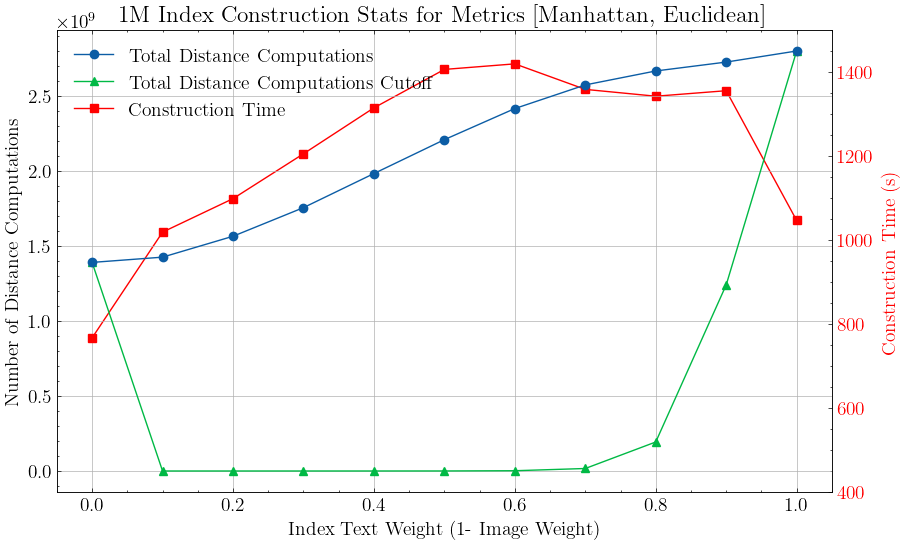

In [37]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["manhattan", "euclidean"], seed=60)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

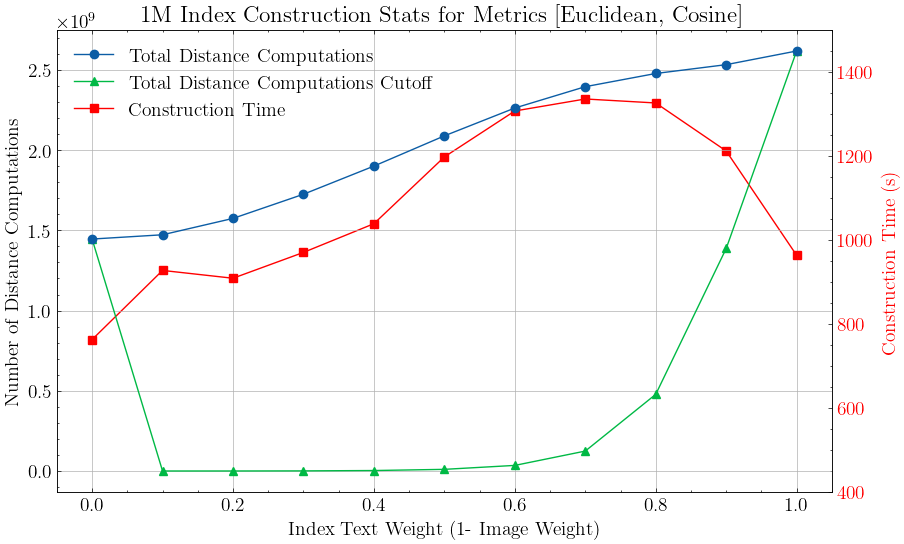

In [38]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "cosine"], seed=60)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

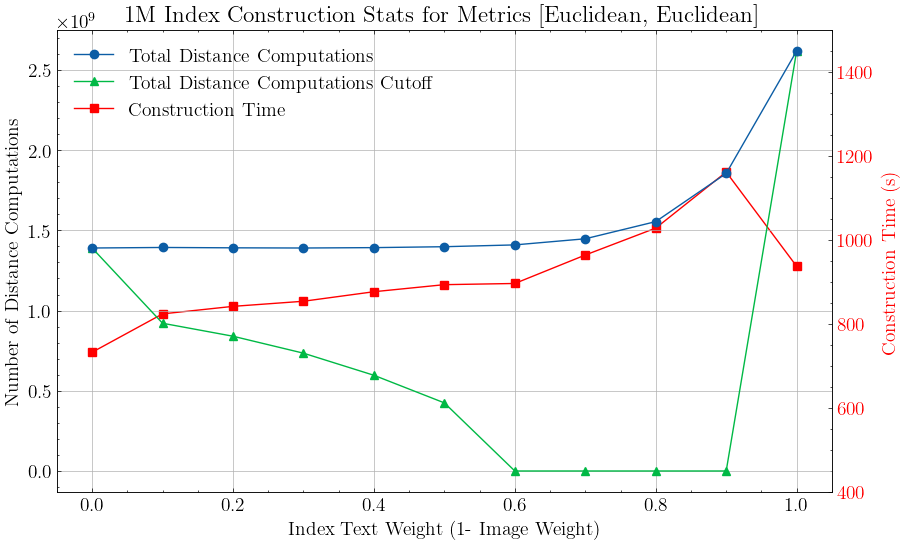

In [39]:
seed = 60
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "euclidean"], seed=60)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed)

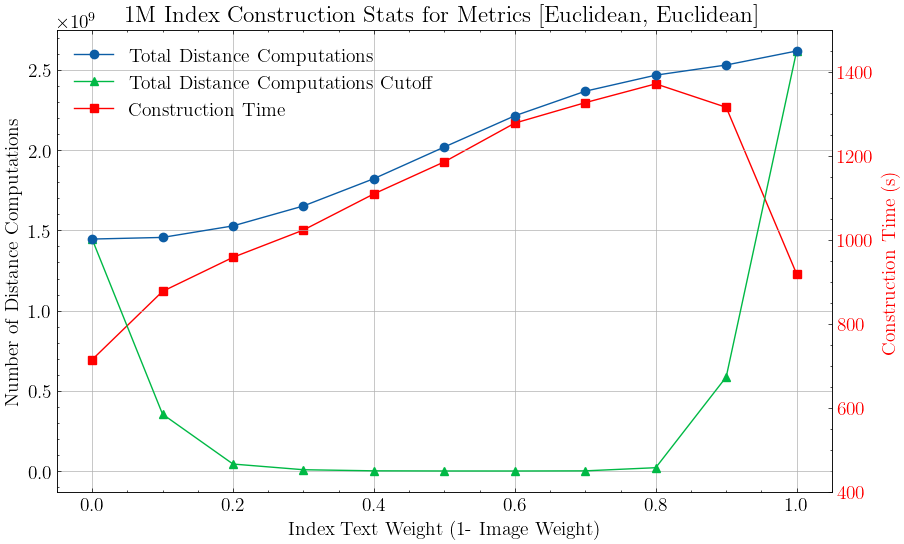

In [40]:
seed = 60
normalised="normalised/"
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "euclidean"], seed=60, normalised=normalised)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed, normalised=normalised)

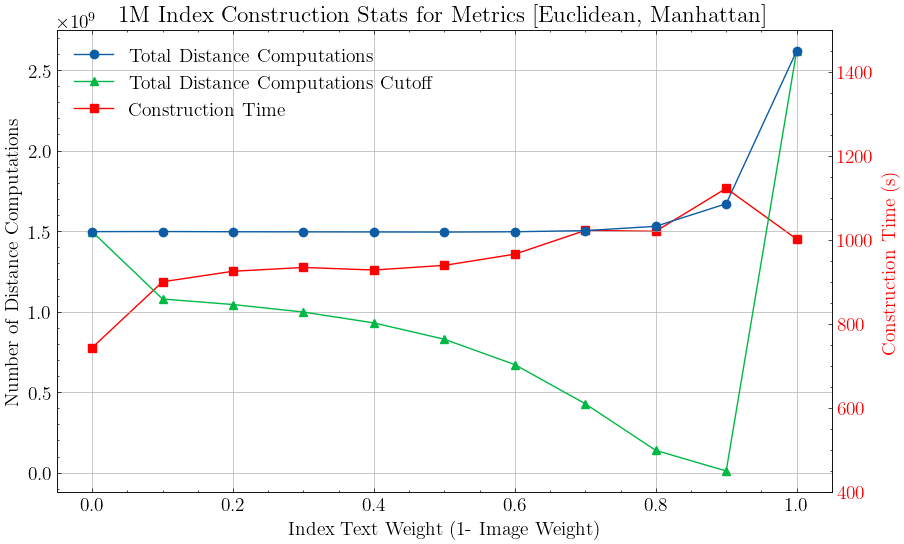

In [41]:
seed = 60
normalised = "normalised/"
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["euclidean", "manhattan"], seed=60, normalised=normalised)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed, normalised=normalised)

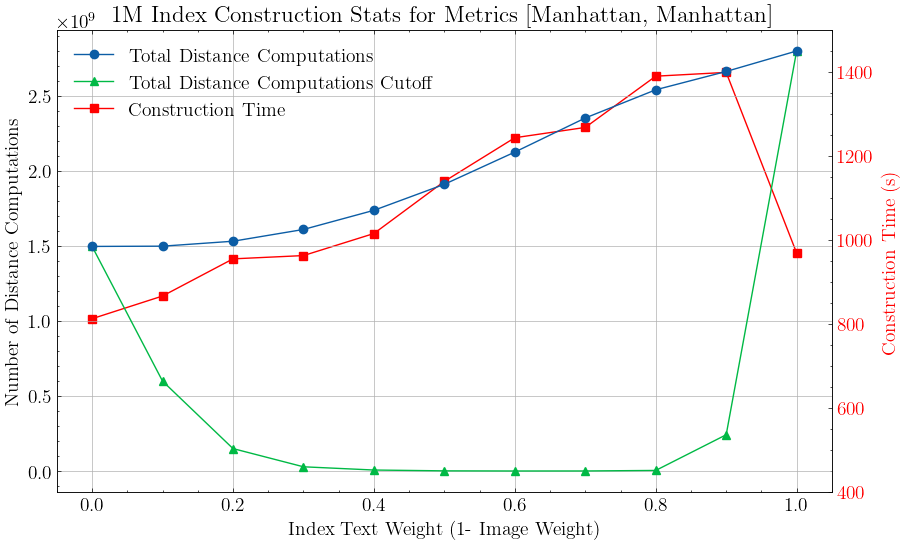

In [42]:
seed = 60
normalised = "normalised/"
params, times, num_compute_distance_calls, num_lazy_distance_calls, total_distance_calls, num_lazy_distance_cutoffs = get_construction_data_per_metric_and_seed(["manhattan", "manhattan"], seed=60, normalised=normalised)

plot_construction_distance_calls(params, times, total_distance_calls, num_lazy_distance_cutoffs, plot_time=True, index_seed=seed, normalised=normalised)

In [20]:
def plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs, plot_dir=PLOT_DIR):
    # plot the distance calls for each text weight
    fig, ax = plt.subplots(figsize=(10, 6))
    assert len(total_distance_calls) == len(num_lazy_distance_cutoffs), f"Length mismatch: {len(total_distance_calls)} vs {len(num_lazy_distance_cutoffs)}"

    # get confidence intervals
    total_distance_means, total_distance_cis = compute_means_and_cis_from_dict_of_list(total_distance_calls)
    cutoff_means, cutoff_cis = compute_means_and_cis_from_dict_of_list(num_lazy_distance_cutoffs)

    # plot total distance and cutoff graphs with confidence intervals
    ax.plot(total_distance_calls.keys(), total_distance_means, label="Total Distance Computations", marker='o', zorder=30, color='blue')
    ax.fill_between(total_distance_calls.keys(), total_distance_means - total_distance_cis, total_distance_means + total_distance_cis, alpha=0.2, zorder=20, color='blue')

    ax.plot(num_lazy_distance_cutoffs.keys(), cutoff_means, label="Total Distance Computations Cutoff", marker='^', zorder=29, color='green')
    ax.fill_between(num_lazy_distance_cutoffs.keys(), cutoff_means - cutoff_cis, cutoff_means + cutoff_cis, alpha=0.2, zorder=20, color='green')

    ax.set_ylabel("Number of Distance Computations")
    ax.set_xlabel("Index Text Weight (1- Image Weight)")
    ax.set_title(f"1M Index Construction Distance Computations for {metrics_to_str(params.metrics)}")
    ax.legend()
    ax.grid()
    # save plot
    if not os.path.exists(f"{plot_dir}/weights-construction"):
        os.makedirs(f"{plot_dir}/weights-construction")
    plt.savefig(f"{plot_dir}/weights-construction/distance_calls_with_ci_{params.index_size}_{params.metrics[0]}-{params.metrics[1]}_seed_MANY.pdf", dpi=FIGURE_DPI, bbox_inches='tight', format='pdf')
    plt.show()

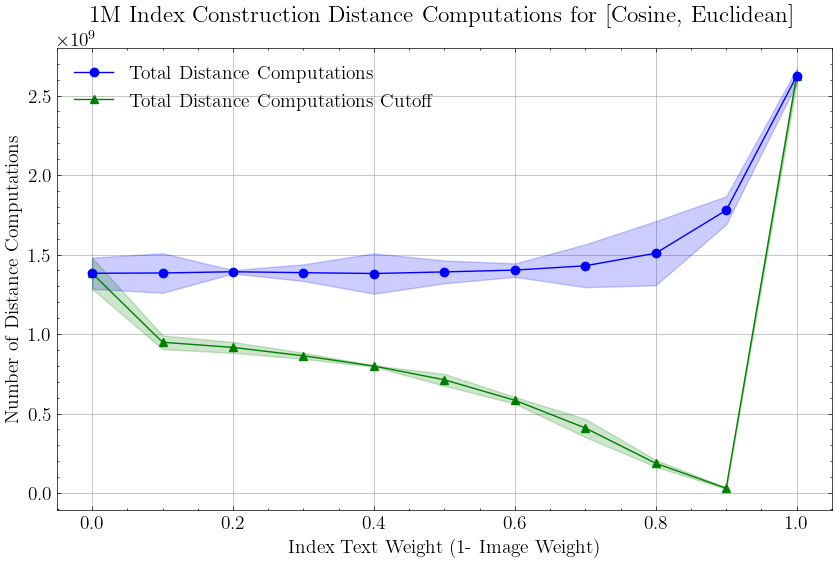

In [228]:
total_distance_calls = defaultdict(list)
num_lazy_distance_cutoffs = defaultdict(list)
for seed in [60, 71]:
    params, _, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed(["cosine", "euclidean"], seed=seed)
    keys = list(total_distance_calls_temp.keys())
    for key in keys:
        total_distance_calls[key].append(total_distance_calls_temp[key])
        num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])

plot_construction_distance_calls_only_with_ci(params, total_distance_calls, num_lazy_distance_cutoffs)

In [28]:
from src.experiments.plot_utils import compute_means_and_cis_from_dict_of_list, metrics_to_str

def plot_construction_distance_calls_for_metrics(metric_to_total_distance_calls, metric_to_num_lazy_distance_cutoffs, plot_dir=PLOT_DIR, index_size=1_000_000, index_seed=None, normalised=""):
    # metric to total distance calls is a dict of dicts

    # plot the distance calls for each text weight
    fig, ax = plt.subplots(figsize=(10, 6))
    assert len(metric_to_total_distance_calls) == len(metric_to_num_lazy_distance_cutoffs), f"Length mismatch: {len(metric_to_total_distance_calls)} vs {len(metric_to_num_lazy_distance_cutoffs)}"

    markers = ['o', 's', '^', 'D', 'x', '+']
    for i, metrics in enumerate(metric_to_total_distance_calls.keys()):
        total_distance_calls = metric_to_total_distance_calls[metrics]
        num_lazy_distance_cutoffs = metric_to_num_lazy_distance_cutoffs[metrics]

        # plot total distance calculations for these metrics
        # plot with marker, but different across each call
        ax.plot(total_distance_calls.keys(), total_distance_calls.values(), label=metrics_to_str(metrics), marker=markers[i%len(markers)])
    ax.set_ylabel("Number of Distance Computations")
    ax.set_xlabel("Index Text Weight (1- Image Weight)")
    ax.set_title("Number of Distance Computations on 1M Index for Different Metrics")
    ax.grid()
    ax.legend(fontsize='x-small')
    # save plot
    if not os.path.exists(f"{plot_dir}/weights-construction"):
        os.makedirs(f"{plot_dir}/weights-construction")
    plt.savefig(f"{plot_dir}/weights-construction/distance_calls_multiple_metrics_{normalised.split('/')[0]}{index_size}_seed_{index_seed}.pdf", dpi=FIGURE_DPI, bbox_inches='tight', format='pdf')
    plt.show()

In [29]:
def get_metrics_data(all_metrics, seed=60, normalised=""):
    metric_to_total_distances = {}
    metric_to_cutoffs = {}
    for metrics in all_metrics:
        # convert tuple to list
        total_distance_calls = defaultdict(list)
        num_lazy_distance_cutoffs = defaultdict(list)
        for seed in [60]:
            instance_normalised = normalised
            if metrics[1] == "cosine":
                instance_normalised = ""
            params, _, _, _, total_distance_calls_temp, num_lazy_distance_cutoffs_temp = get_construction_data_per_metric_and_seed([i for i in metrics], seed=seed, normalised=instance_normalised)
            keys = list(total_distance_calls_temp.keys())
            for key in keys:
                total_distance_calls[key].append(total_distance_calls_temp[key])
                num_lazy_distance_cutoffs[key].append(num_lazy_distance_cutoffs_temp[key])

        metric_to_total_distances[metrics] = total_distance_calls
        metric_to_cutoffs[metrics] = num_lazy_distance_cutoffs

    return metric_to_total_distances, metric_to_cutoffs

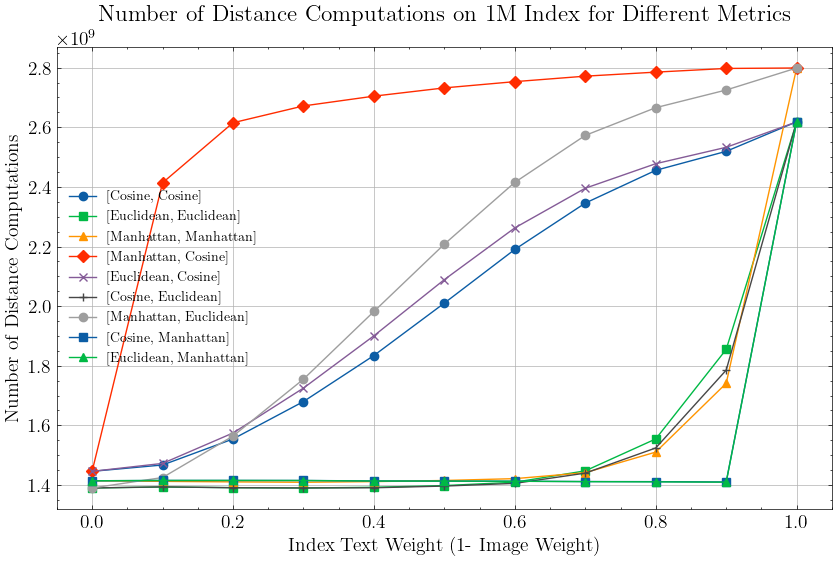

In [30]:
metric_to_total_distances, metric_to_cutoffs = get_metrics_data([("cosine", "cosine"), ("euclidean", "euclidean"), ("manhattan", "manhattan"), ("manhattan", "cosine"), ("euclidean", "cosine"), ("cosine", "euclidean"), ("manhattan", "euclidean"), ("cosine", "Manhattan"), ("euclidean", "Manhattan")])
plot_construction_distance_calls_for_metrics(metric_to_total_distances, metric_to_cutoffs, index_size=1000000, index_seed=60)

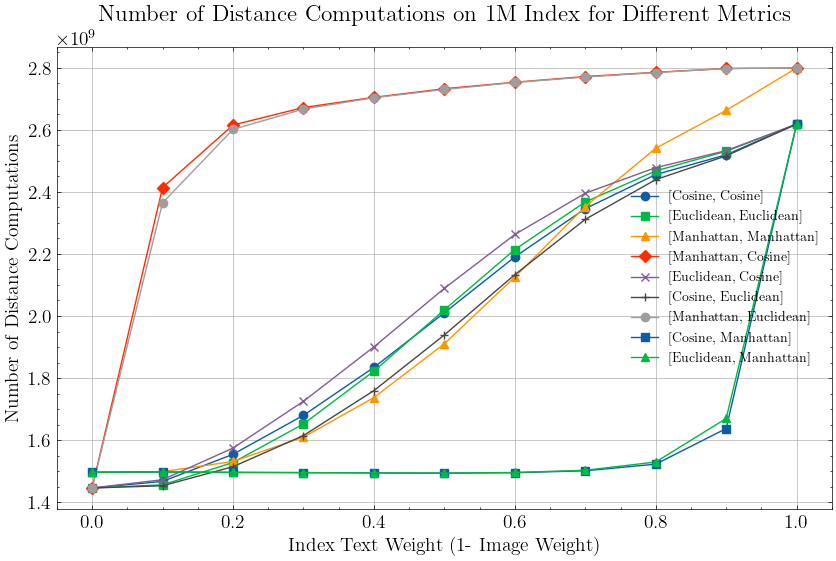

In [31]:
normalised = "normalised/"
metric_to_total_distances, metric_to_cutoffs = get_metrics_data([("cosine", "cosine"), ("euclidean", "euclidean"),  ("manhattan", "manhattan"), ("manhattan", "cosine"), ("euclidean", "cosine"),  ("cosine", "euclidean"), ("manhattan", "euclidean"), ("cosine", "manhattan"), ("euclidean", "manhattan")], normalised=normalised)
plot_construction_distance_calls_for_metrics(metric_to_total_distances, metric_to_cutoffs, index_size=1000000, index_seed=60, normalised=normalised)

In [ ]:
# plot recall at search weights equal to various constructed weights

In [166]:
def get_recall_at_indexweights_data(metrics, construction_params, base_folder=STATS_BASE_FOLDER + "search_weights_exps/"
, prev_experiment_folder=1, bracket_split_char="-", normalised="normalised/"):
    assert len(metrics) == 2
    recall_data = defaultdict(lambda: defaultdict(list)) # index_text_weight -> ef -> recall
    base_folder += normalised
    for index_text_weight in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        print(index_text_weight)
        index_image_weight = round(1-index_text_weight, 4)

        params = Params(modalities=2, dimensions=[384, 768], metrics=metrics, weights=[index_text_weight, index_image_weight], index_size=1_000_000)

        folder = base_folder + get_construction_folder(params, bracket_split_char) + get_hnsw_construction_params_folder(construction_params, bracket_split_char)
        index_folder = get_latest_experiment_folder(folder)
        exps_folder = os.path.join(folder, index_folder)
        exp_folder = os.path.join(folder, index_folder, get_latest_experiment_folder(exps_folder, prev_experiment_folder))
        search_weights_folders = os.listdir(exp_folder)

        for search_weights_folder in search_weights_folders:
            if search_weights_folder.startswith("."):
                continue

            search_weights = search_weights_folder.split(bracket_split_char)[1]
            text_weight = float(search_weights.split(",")[0])

            if text_weight != index_text_weight:
                continue
            for ef_folder in os.listdir(exp_folder + "/" + search_weights_folder):
                if ef_folder.startswith("."):
                    continue
                stats = ef_folder.split("_")
                k = int(stats[0])
                ef = int(stats[1])

                if ef >=k:
                    # load results.npz file
                    results = np.load(os.path.join(exp_folder, search_weights_folder, ef_folder, "results.npz"))
                    # results contains recall_scores, ef_search
                    assert ef == results["ef_search"]
                    recall_data[text_weight][ef].append(results["recall_scores"])

    return recall_data, k

In [167]:
def plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=float('inf'), plots_dir=PLOT_DIR, plot_by_image_weight=False):
    # recall_data is index_weights -> ef -> list of recall for 100 queries
    # we have 11 values for weights: 0.0 to 1.0, and around 15 for ef
    # for each cell combination, we plot a heatmap of the average of the recall values
    print("initial length:", len(recall_data[0.3][50]))
    if plot_by_image_weight:
        # we plot image weights, so first transform to 1-text_weight
        transformed_data = {}
        for weight, ef_dict in recall_data.items():
            new_weight = round(1.0 - weight, 5)
            transformed_data[new_weight] = ef_dict
    else:
        transformed_data = recall_data

    weights = sorted(transformed_data.keys())
    efs = sorted({ef for ef_dict in transformed_data.values() for ef in ef_dict if ef <= max_ef})
    print(efs)

    heatmap_data = np.zeros((len(weights), len(efs)))
    for i, weight in enumerate(weights):
        print(f"weight {weight} has {len(transformed_data[weight][50][0])} items")
        for j, ef in enumerate(efs):
            recall_list = transformed_data[weight][ef]
            assert len(recall_list) > 0, f"Missing data for weight {weight} and ef {ef}"
            heatmap_data[i, j] = np.mean(recall_list)

    plt.figure(figsize=(10, 6))
    im = plt.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis') #viridis, YlGn, summer

    plt.xticks(ticks=np.arange(len(efs)), labels=efs)
    plt.yticks(ticks=np.arange(len(weights)), labels=[f"{w:.1f}" for w in weights])

    plt.xlabel("efSearch")
    plt.ylabel("Image Index Weight (1 - Text Index Weight)")
    plt.title(f"Recall Heatmap for Varying Index Weights with Metrics {metrics_to_str(metrics)}")

    plt.colorbar(im, label="Average Recall")

    plt.tight_layout()

    # save plot
    subdir= "index_weights_recall"
    if not os.path.exists(f"{plots_dir}/{subdir}"):
        os.makedirs(f"{plots_dir}/{subdir}")
    print(params.weights[0],int(params.weights[0]*100))
    plt.savefig(f"{plots_dir}/{subdir}/recall_heatmap_1M_{metrics[0]}_{metrics[1]}_ef{construction_params.ef_construction}_seed_{construction_params.seed}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [170]:
construction_params = MultiVecHNSWConstructionParams(target_degree=16, max_degree=16, ef_construction=100, seed=60)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
initial length: 1
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
weight 0.0 has 1000 items
weight 0.1 has 1000 items
weight 0.2 has 1000 items
weight 0.3 has 1000 items
weight 0.4 has 1000 items
weight 0.5 has 1000 items
weight 0.6 has 1000 items
weight 0.7 has 1000 items
weight 0.8 has 1000 items
weight 0.9 has 1000 items
weight 1.0 has 1000 items
1.0 100


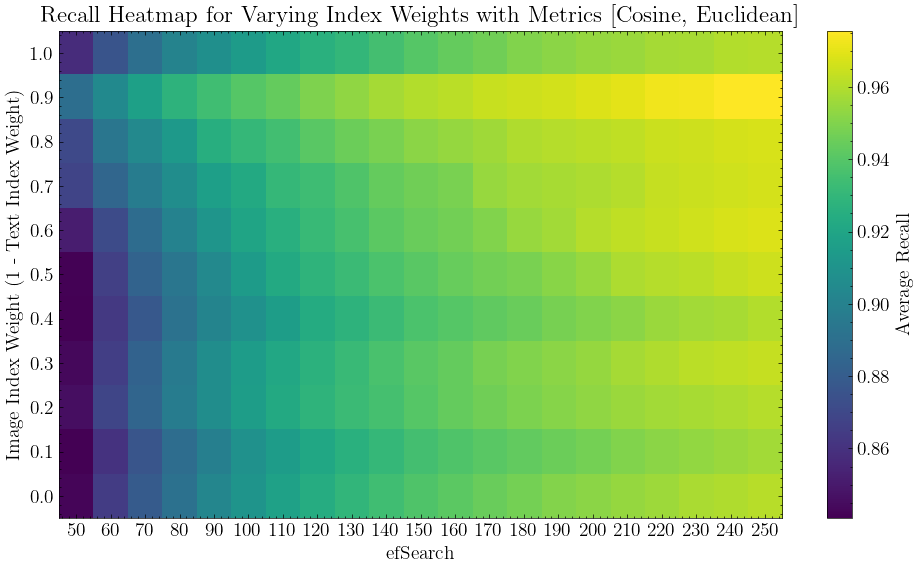

In [173]:
metrics = ["cosine", "euclidean"]
recall_data, k = get_recall_at_indexweights_data(metrics, construction_params)
plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=250, plot_by_image_weight=True)

In [155]:
len(recall_data[0.3][50][0])

1000

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
initial length: 1
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
weight 0.0 has 100 items
weight 0.1 has 100 items
weight 0.2 has 100 items
weight 0.3 has 100 items
weight 0.4 has 100 items
weight 0.5 has 100 items
weight 0.6 has 100 items
weight 0.7 has 100 items
weight 0.8 has 100 items
weight 0.9 has 100 items
weight 1.0 has 100 items
1.0 100


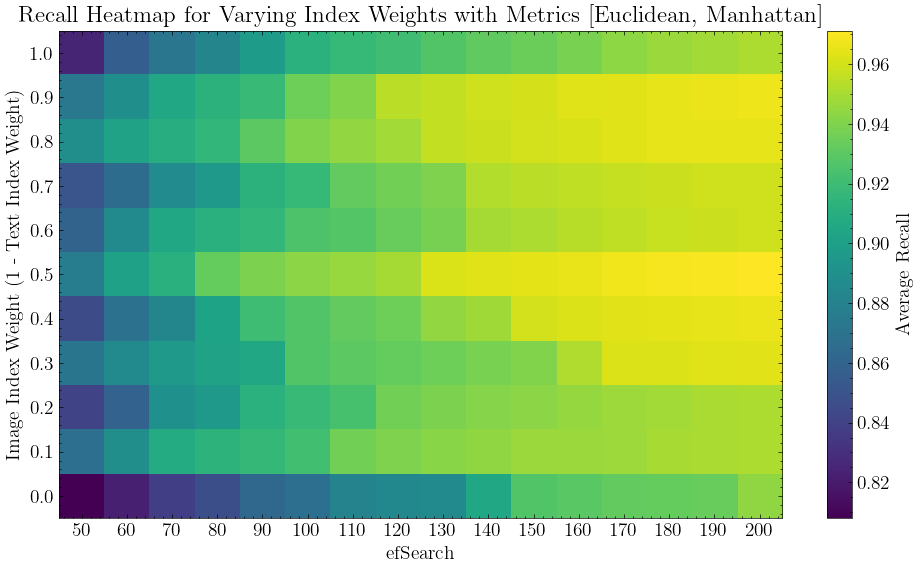

In [172]:
metrics = ["euclidean", "manhattan"]
recall_data, k = get_recall_at_indexweights_data(metrics, construction_params)
plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=200)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
initial length: 1
[50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
weight 0.0 has 1000 items
weight 0.1 has 1000 items
weight 0.2 has 1000 items
weight 0.3 has 1000 items
weight 0.4 has 1000 items
weight 0.5 has 1000 items
weight 0.6 has 1000 items
weight 0.7 has 1000 items
weight 0.8 has 1000 items
weight 0.9 has 1000 items
weight 1.0 has 1000 items
1.0 100


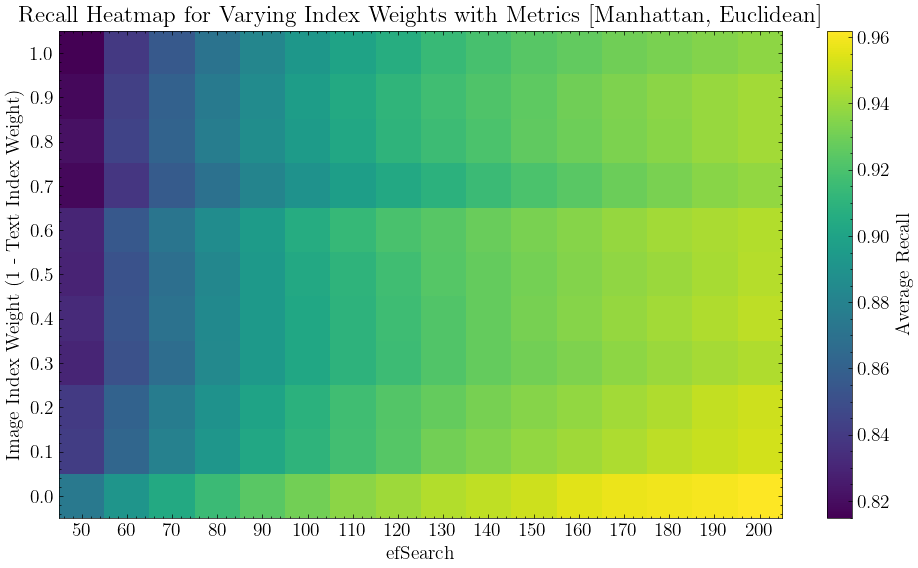

In [176]:
metrics = ["manhattan", "euclidean"]
recall_data, k = get_recall_at_indexweights_data(metrics, construction_params)
plot_heatmap_for_index_weights_recall_data(metrics, construction_params, recall_data, max_ef=200)